In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 1. Data 불러오기

In [ ]:
df = pd.read_csv("BankChurners.csv")
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


# 2. Data Cleaning

In [ ]:
# 필요없는 변수 제거
df.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],axis=1,inplace=True)

In [ ]:
# Unknown이 있는 범주형 컬럼의 최빈값 확인
print(df['Marital_Status'].value_counts(), '\n')
print(df['Education_Level'].value_counts(), '\n')
print(df['Income_Category'].value_counts())

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64 

Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64 

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64


In [ ]:
# Unknown 값을 최빈값으로 대체
df['Marital_Status'] = df['Marital_Status'].replace({'Unknown':'Married'})
df['Education_Level'] = df['Education_Level'].replace({'Unknown':'Graduate'})
df['Income_Category'] = df['Income_Category'].replace({'Unknown':'Less than $40K'})

In [ ]:
# 문자값을 숫자로 변경
df['Attrition_Flag'] = df['Attrition_Flag'].replace({'Existing Customer':0,'Attrited Customer':1})
df['Gender'] = df['Gender'].replace({'M':0, 'F':1})

In [ ]:
# 나이 변수 범주화
df['Age_Category']=pd.cut(df['Customer_Age'], bins=[25,35,45,55,np.inf], labels=['26~35', '36~45', '46~55', '56~'])
df.drop(['Customer_Age'],axis=1,inplace=True)

In [ ]:
# 범주형 변수 원핫인코딩
categorical = ['Age_Category','Education_Level','Marital_Status','Income_Category','Card_Category']
df2 = pd.get_dummies(df, columns=categorical, prefix=['Age','Edu','Status','Income','Card'], drop_first=True)

In [ ]:
df2.head()

,Attrition_Flag,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Edu_Uneducated,Status_Married,Status_Single,Income_$40K - $60K,Income_$60K - $80K,Income_$80K - $120K,Income_Less than $40K,Card_Gold,Card_Platinum,Card_Silver
0,0,0,3,39,5,1,3,12691.0,777,11914.0,...,0,1,0,0,1,0,0,0,0,0
1,0,1,5,44,6,1,2,8256.0,864,7392.0,...,0,0,1,0,0,0,1,0,0,0
2,0,0,3,36,4,1,0,3418.0,0,3418.0,...,0,1,0,0,0,1,0,0,0,0
3,0,1,4,34,3,4,1,3313.0,2517,796.0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,3,21,5,1,0,4716.0,0,4716.0,...,1,1,0,0,1,0,0,0,0,0


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Gender                    10127 non-null  int64  
 2   Dependent_count           10127 non-null  int64  
 3   Months_on_book            10127 non-null  int64  
 4   Total_Relationship_Count  10127 non-null  int64  
 5   Months_Inactive_12_mon    10127 non-null  int64  
 6   Contacts_Count_12_mon     10127 non-null  int64  
 7   Credit_Limit              10127 non-null  float64
 8   Total_Revolving_Bal       10127 non-null  int64  
 9   Avg_Open_To_Buy           10127 non-null  float64
 10  Total_Amt_Chng_Q4_Q1      10127 non-null  float64
 11  Total_Trans_Amt           10127 non-null  int64  
 12  Total_Trans_Ct            10127 non-null  int64  
 13  Total_Ct_Chng_Q4_Q1       10127 non-null  float64
 14  Avg_Ut

# 3. 시각화

## 1) T-SNE 시각화

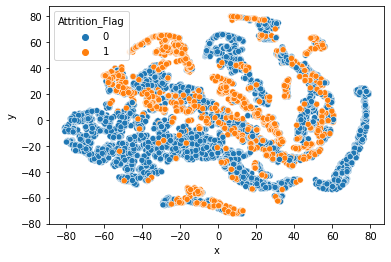

In [ ]:
# t-SNE를 사용한 시각화
from itertools import cycle
tsnedf = df2.copy()

model = TSNE(learning_rate=100)
tsne_features = model.fit_transform(tsnedf)

tsnedf['x'] = tsne_features[:,0]
tsnedf['y'] = tsne_features[:,1]

sns.scatterplot(x="x", y="y", hue="Attrition_Flag", data=tsnedf)
plt.show()

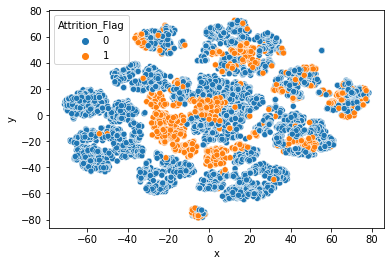

In [ ]:
# t-SNE를 사용한 시각화 (Standard Scaling 적용)
from itertools import cycle
tsnedf = df2.copy()

standard_scaler = StandardScaler()
tsnedf_std = standard_scaler.fit_transform(tsnedf)

model = TSNE(learning_rate=100)
tsne_features = model.fit_transform(tsnedf_std)

tsnedf['x'] = tsne_features[:,0]
tsnedf['y'] = tsne_features[:,1]

sns.scatterplot(x="x", y="y", hue="Attrition_Flag", data=tsnedf)
plt.show()

## 2) 종속변수 분포 확인

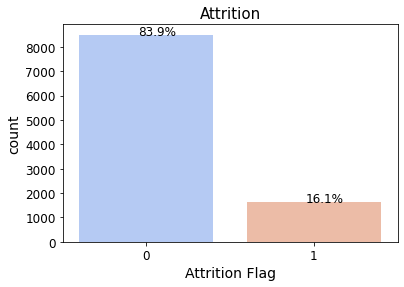

In [ ]:
# 종속변수 분포 확인
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Attrition_Flag' , data=df ,palette='coolwarm')
plt.xticks(size = 12)
plt.xlabel('Attrition Flag', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.yticks(size = 12)
plt.title("Attrition", size = 15)
precent_maker(ax, df.Attrition_Flag)

## 3) 설명변수 분포 확인

In [ ]:
# 'Age_Category' 데이터타입을 'object'로 변경
df = df.astype({'Age_Category': 'object'})
df = df.astype({'Gender': 'object'})

In [ ]:
# 범주형 변수와 연속형 변수 구분
num = df.select_dtypes('number').columns.to_list()
del num[0] #Attrition_Flag 제거
cat = df.select_dtypes('object').columns.to_list()

In [ ]:
# 시각화 위한 컬럼 percentage 계산 함수
def precent_maker(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

### a. 설명변수 중 범주형 변수의 분포 확인

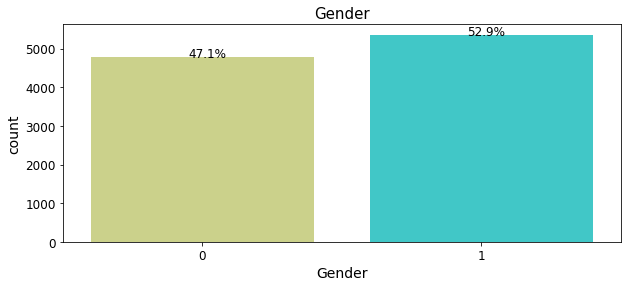

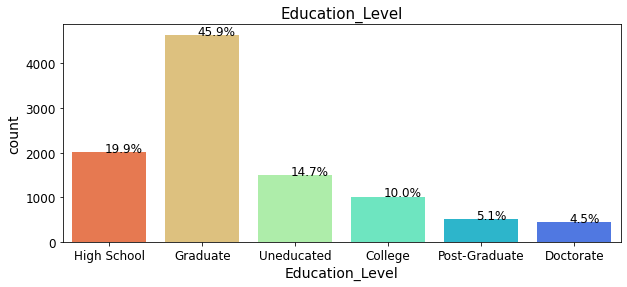

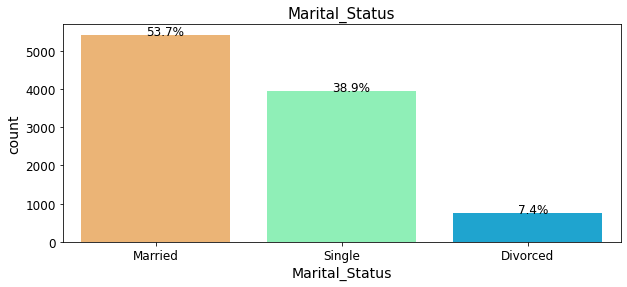

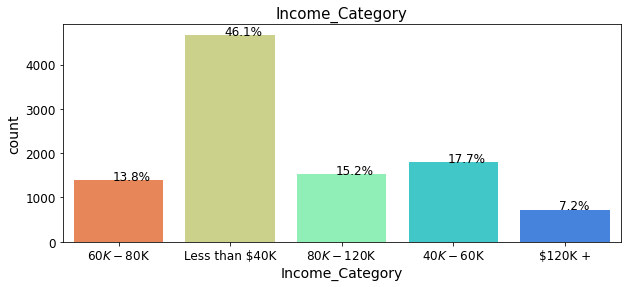

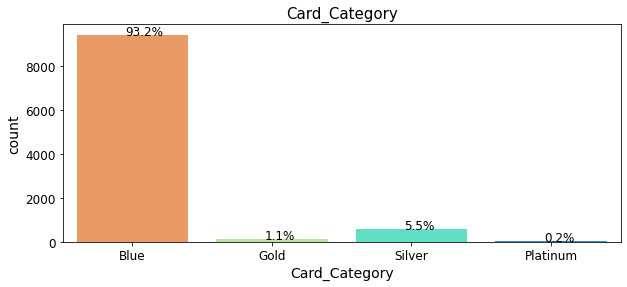

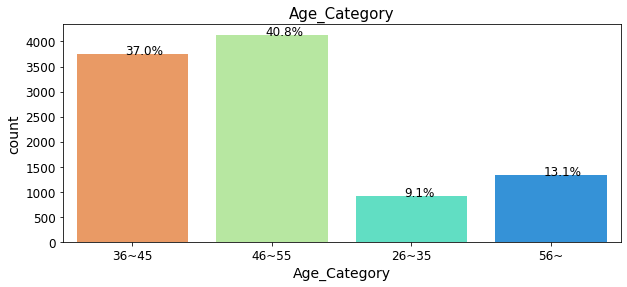

In [ ]:
# 설명변수 중 범주형 변수 분포 확인
for i in cat:
    plt.figure(figsize=(10,4))
    ax = sns.countplot(x=i , data=df ,palette='rainbow_r')
    plt.xticks(size = 12)
    plt.xlabel(i, fontsize=14)
    plt.ylabel('count', fontsize=14)
    plt.yticks(size = 12)
    plt.title(i, size = 15)
    precent_maker(ax, df[i])

### b. Attrition 여부에 따른 범주형 설명변수의 분포 (피드백 이전 코드)

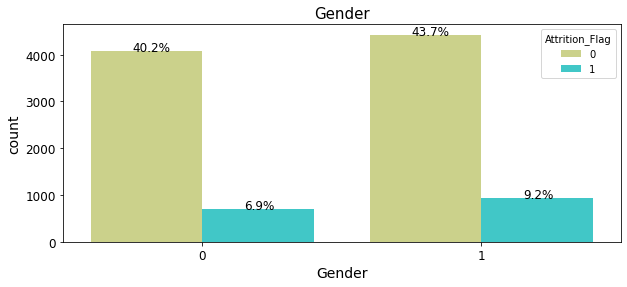

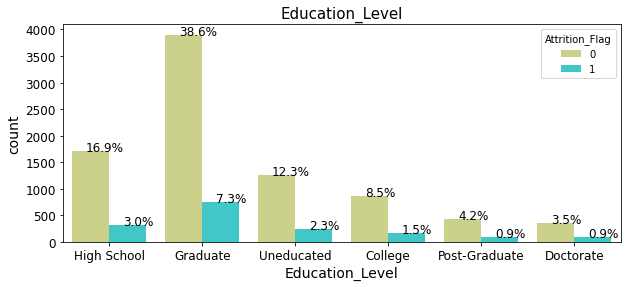

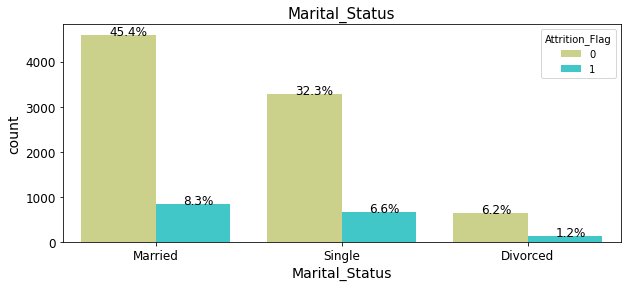

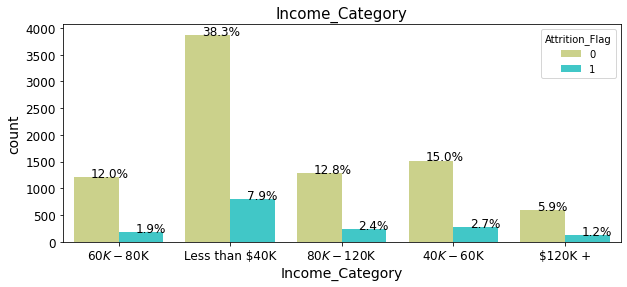

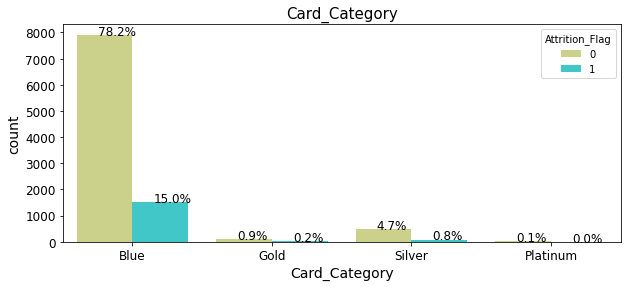

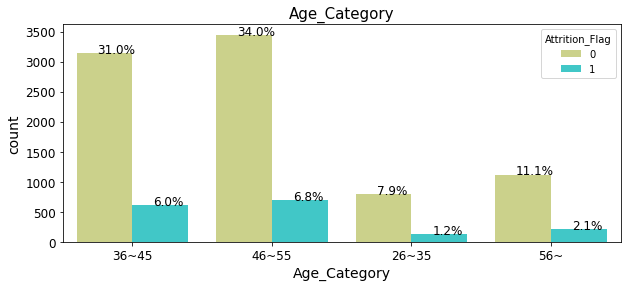

In [ ]:
# Attrition 여부에 따른 범주형 설명변수의 분포
for i in cat:
    plt.figure(figsize=(10,4))
    ax = sns.countplot(x=i , data=df, hue = 'Attrition_Flag' ,palette='rainbow_r')
    plt.xticks(size = 12)
    plt.xlabel(i, fontsize=14)
    plt.ylabel('count', fontsize=14)
    plt.yticks(size = 12)
    plt.title(i, size = 15)
    precent_maker(ax, df[i])

### c. 범주형 설명변수에 대하여 속성별 해지율 그래프 그리기 (피드백 이후 추가 코드)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  int64   
 1   Gender                    10127 non-null  int64   
 2   Dependent_count           10127 non-null  int64   
 3   Education_Level           10127 non-null  object  
 4   Marital_Status            10127 non-null  object  
 5   Income_Category           10127 non-null  object  
 6   Card_Category             10127 non-null  object  
 7   Months_on_book            10127 non-null  int64   
 8   Total_Relationship_Count  10127 non-null  int64   
 9   Months_Inactive_12_mon    10127 non-null  int64   
 10  Contacts_Count_12_mon     10127 non-null  int64   
 11  Credit_Limit              10127 non-null  float64 
 12  Total_Revolving_Bal       10127 non-null  int64   
 13  Avg_Open_To_Buy           10127 non-null  floa

In [ ]:
# 범주형 설명변수들로만 구성된 데이터프레임 만들기
# 주의: 종속변수인 Attrition_Flag도 빼먹지 말고 넣어주기
df_cat = df.iloc[:,[0,1,3,4,5,6,19]]   
df_cat.head()

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Age_Category
0,0,0,High School,Married,$60K - $80K,Blue,36~45
1,0,1,Graduate,Single,Less than $40K,Blue,46~55
2,0,0,Graduate,Married,$80K - $120K,Blue,46~55
3,0,1,High School,Married,Less than $40K,Blue,36~45
4,0,0,Uneducated,Married,$60K - $80K,Blue,36~45


In [ ]:
# Gender 컬럼을 문자값으로 변경해주기
df_cat['Gender'] = df_cat['Gender'].replace({0: 'Male', 1: 'Female'})
df_cat.head()

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Age_Category
0,0,Male,High School,Married,$60K - $80K,Blue,36~45
1,0,Female,Graduate,Single,Less than $40K,Blue,46~55
2,0,Male,Graduate,Married,$80K - $120K,Blue,46~55
3,0,Female,High School,Married,Less than $40K,Blue,36~45
4,0,Male,Uneducated,Married,$60K - $80K,Blue,36~45


In [ ]:
# value count를 위한 임시 컬럼 추가
df_cat['Count'] = 1
df_cat.head()

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Age_Category,Count
0,0,Male,High School,Married,$60K - $80K,Blue,36~45,1
1,0,Female,Graduate,Single,Less than $40K,Blue,46~55,1
2,0,Male,Graduate,Married,$80K - $120K,Blue,46~55,1
3,0,Female,High School,Married,Less than $40K,Blue,36~45,1
4,0,Male,Uneducated,Married,$60K - $80K,Blue,36~45,1


In [ ]:
# 피벗 테이블 생성
att_gender = df_cat.pivot_table(index=df_cat['Gender'], aggfunc='sum')
att_education = df_cat.pivot_table(index=df_cat['Education_Level'], aggfunc='sum')
att_marital = df_cat.pivot_table(index=df_cat['Marital_Status'], aggfunc='sum')
att_income = df_cat.pivot_table(index=df_cat['Income_Category'], aggfunc='sum')
att_card = df_cat.pivot_table(index=df_cat['Card_Category'], aggfunc='sum')
att_age = df_cat.pivot_table(index=df_cat['Age_Category'], aggfunc='sum')

In [ ]:
# 해지율 컬럼 추가 & 높은 순서대로 정렬
att_list = [att_gender, att_education, att_marital, att_income, att_card, att_age]

for i in att_list:
    i['Ratio'] = round(i['Attrition_Flag'] / i['Count'] * 100, 2)
    i.sort_values(by=['Ratio'], ascending=False, inplace=True)
    print(i, '\n')

        Attrition_Flag  Count  Ratio
Gender                              
Female             930   5358  17.36
Male               697   4769  14.62 

                 Attrition_Flag  Count  Ratio
Education_Level                              
Doctorate                    95    451  21.06
Post-Graduate                92    516  17.83
Graduate                    743   4647  15.99
Uneducated                  237   1487  15.94
College                     154   1013  15.20
High School                 306   2013  15.20 

                Attrition_Flag  Count  Ratio
Marital_Status                              
Single                     668   3943  16.94
Divorced                   121    748  16.18
Married                    838   5436  15.42 

                 Attrition_Flag  Count  Ratio
Income_Category                              
$120K +                     126    727  17.33
Less than $40K              799   4673  17.10
$80K - $120K                242   1535  15.77
$40K - $60K            

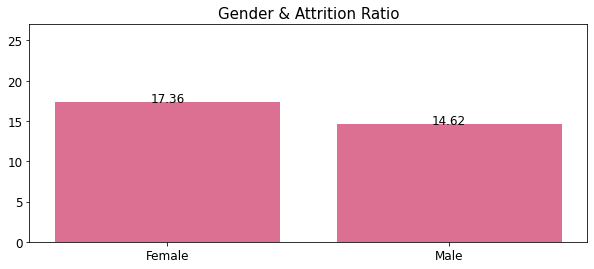

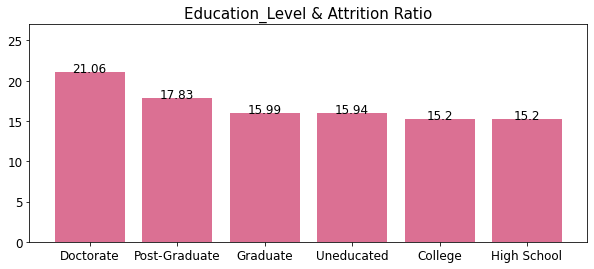

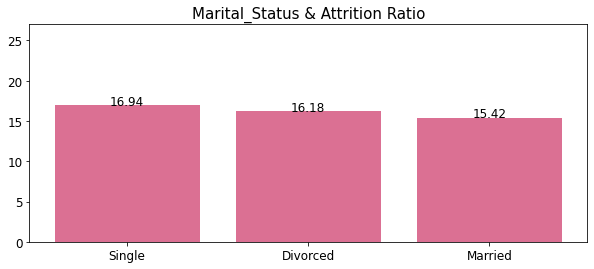

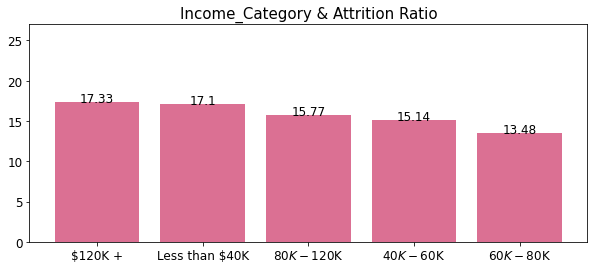

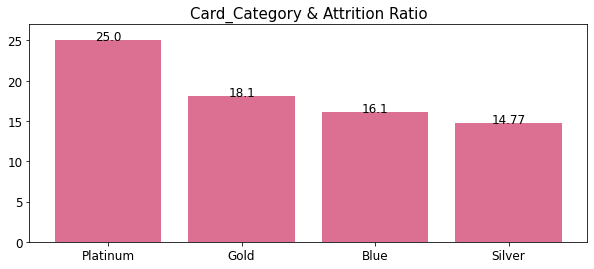

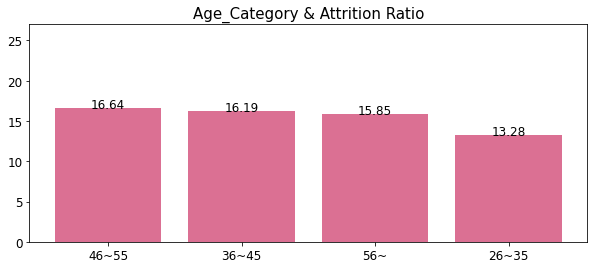

In [ ]:
# 그래프 그리기
title_list = ['Gender & Attrition Ratio', 
              'Education_Level & Attrition Ratio',
              'Marital_Status & Attrition Ratio',
              'Income_Category & Attrition Ratio',
              'Card_Category & Attrition Ratio',
              'Age_Category & Attrition Ratio']

for i, j in zip(att_list, title_list):
  
    plt.figure(figsize=(10, 4))
    plt.title(j, size=15)
    plt.bar(i.index, i['Ratio'], color='palevioletred')
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.ylim([0, 27])
    
    text = i['Ratio']
    for k in range(text.shape[0]):
        plt.text(k, text[k], text[k],
                 ha='center', fontsize=12)

    #plt.savefig(j)
    plt.show()

### d. 연속형 설명변수의 분포 시각화

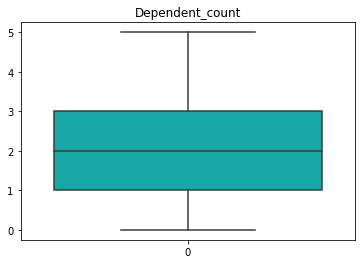

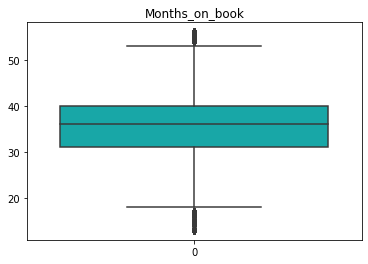

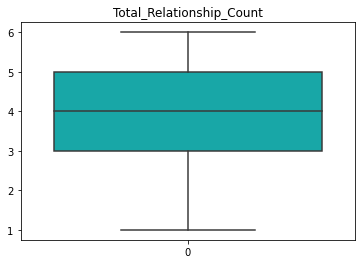

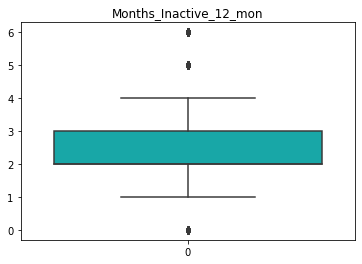

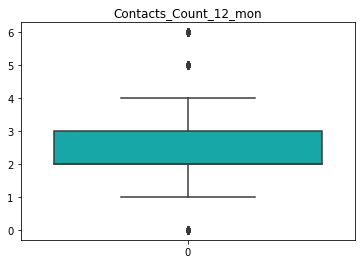

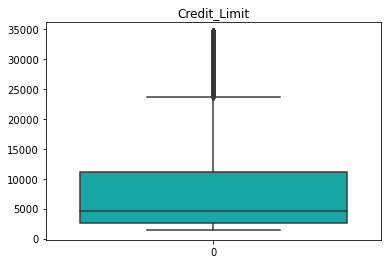

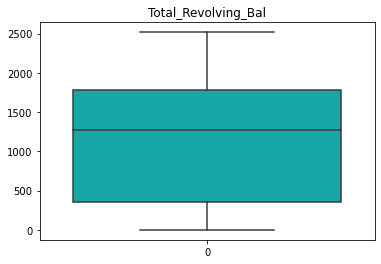

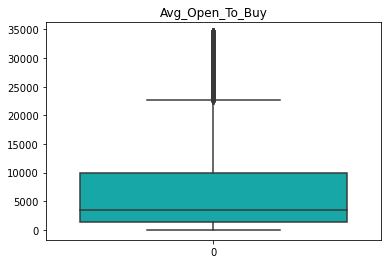

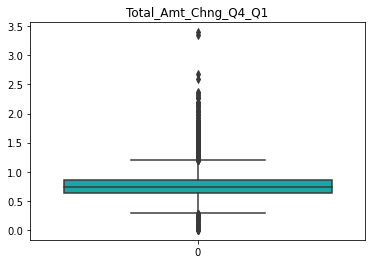

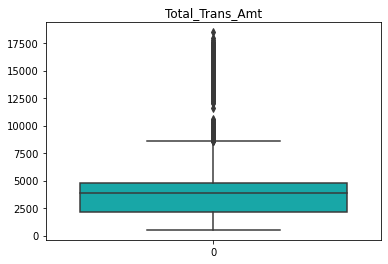

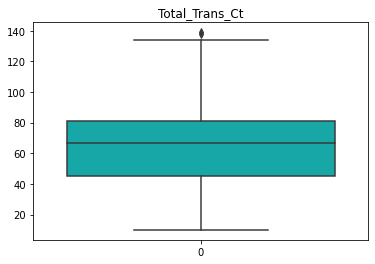

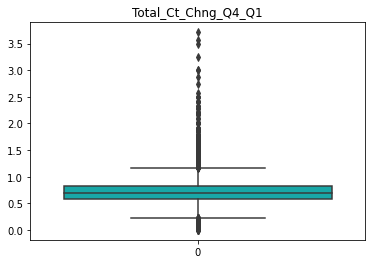

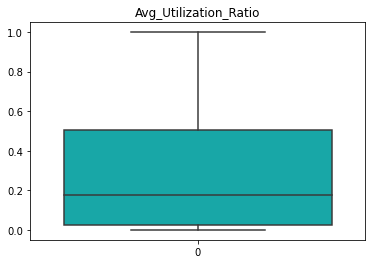

In [ ]:
# 연속형 설명변수 분포 (Box Plot)
for numeric in df[num]:
    sns.boxplot(data=df[numeric],orient="v", color = 'c')
    plt.title(numeric)
    plt.show()

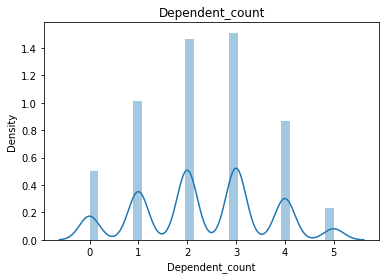

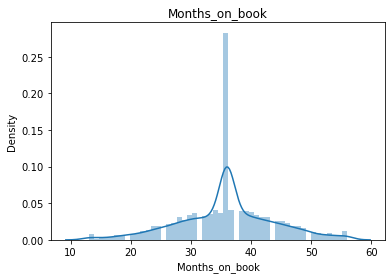

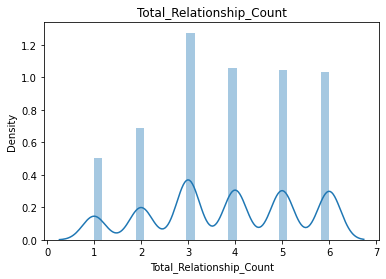

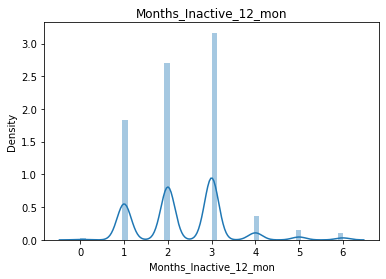

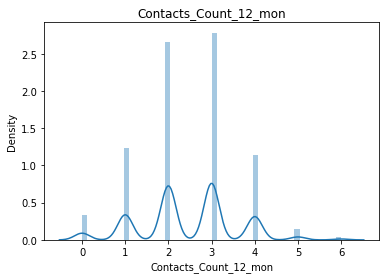

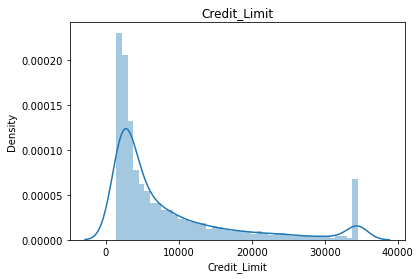

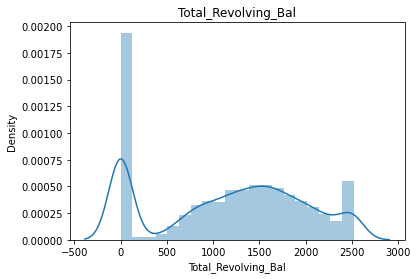

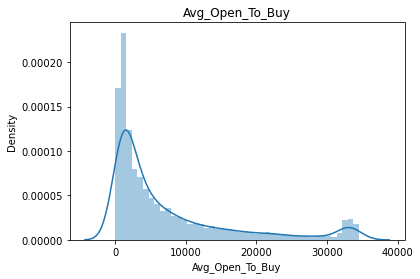

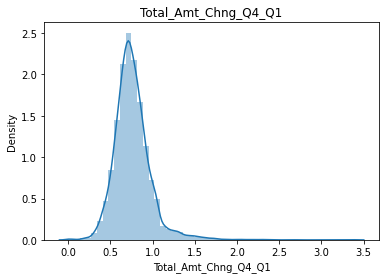

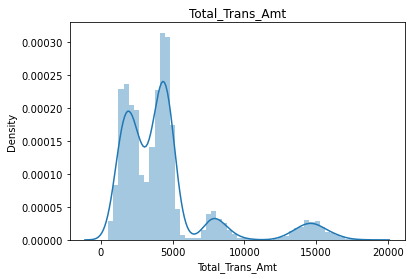

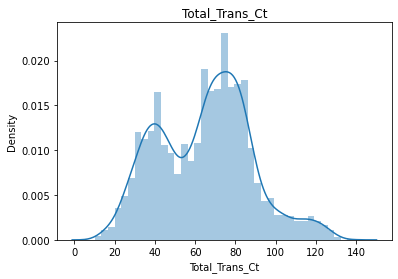

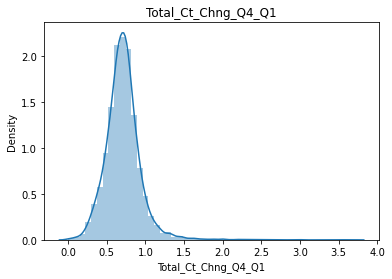

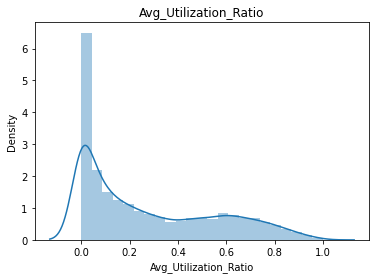

In [ ]:
# 연속형 설명변수 분포 (히스토그램)
for numeric in df[num]:
    sns.distplot(df[numeric])
    plt.title(numeric)
    plt.show()

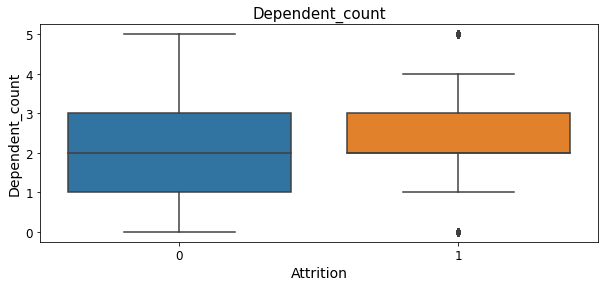

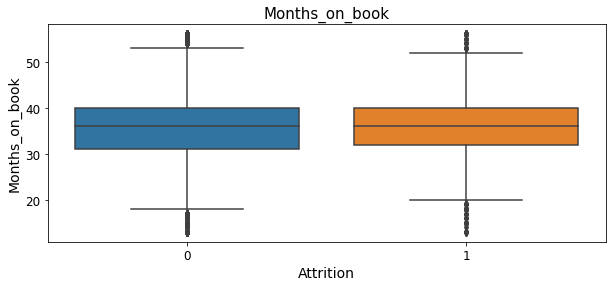

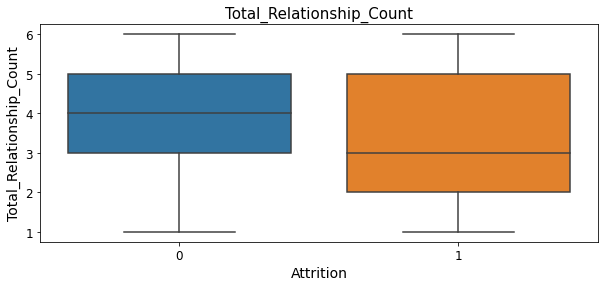

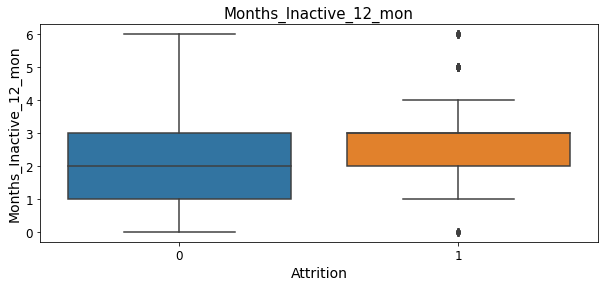

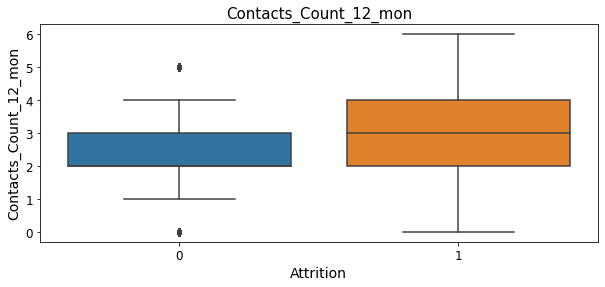

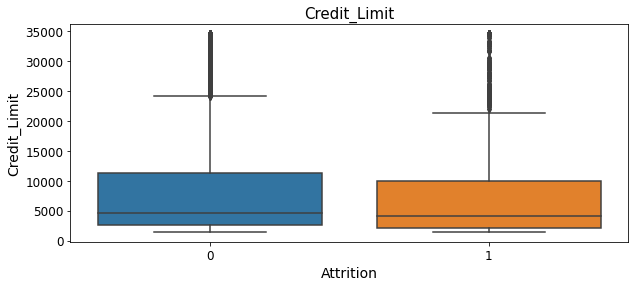

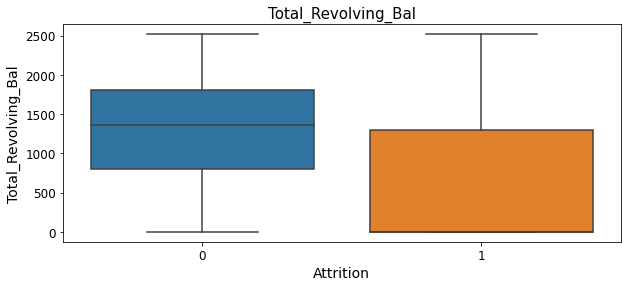

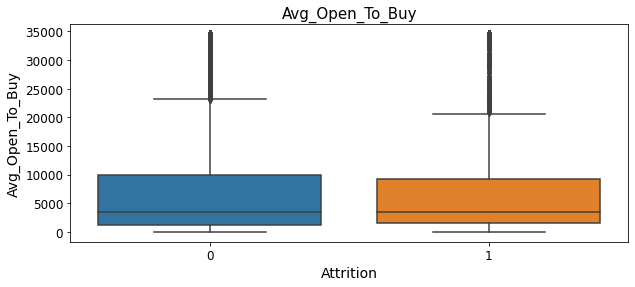

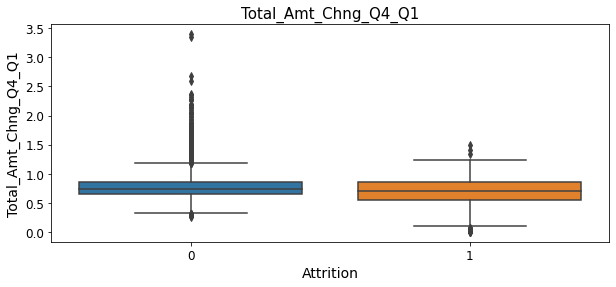

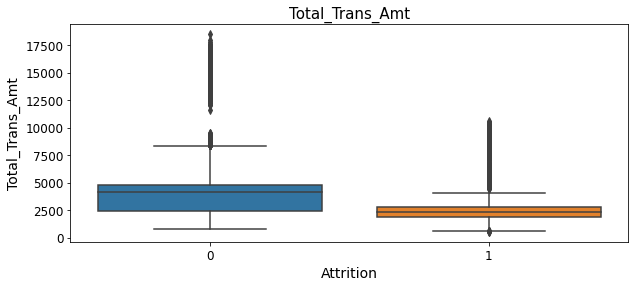

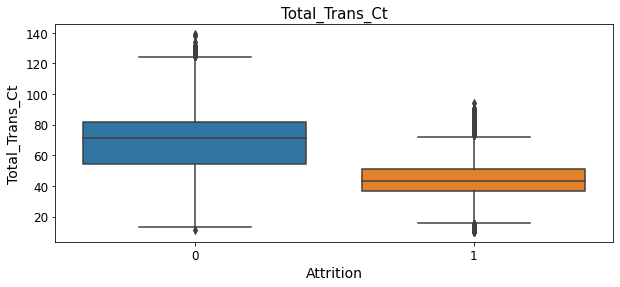

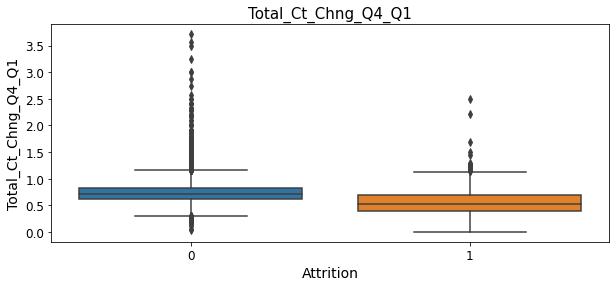

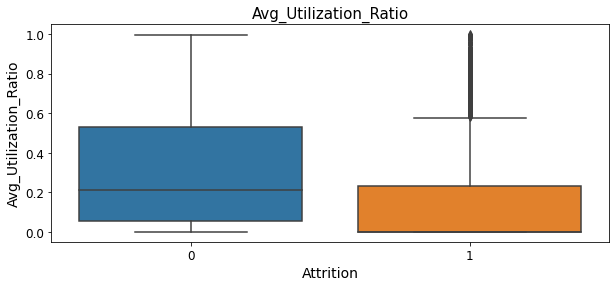

In [ ]:
# Attition 여부에 따른 연속형 설명변수 분포 
for i in num:
    plt.figure(figsize=(10,4))
    ax = sns.boxplot(x='Attrition_Flag', y=i, data=df)
    plt.xticks(size = 12)
    plt.xlabel('Attrition', fontsize=14)
    plt.ylabel(i, fontsize=14)
    plt.yticks(size = 12)
    plt.title(i, size = 15)

# 4. 전처리

## 1) 차원축소

In [ ]:
# 설명변수와 종속변수 설정
X = df2.drop('Attrition_Flag', axis=1)
y = df2['Attrition_Flag']

X.columns

Index(['Gender', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Age_36~45', 'Age_46~55', 'Age_56~', 'Edu_Doctorate', 'Edu_Graduate',
       'Edu_High School', 'Edu_Post-Graduate', 'Edu_Uneducated',
       'Status_Married', 'Status_Single', 'Income_$40K - $60K',
       'Income_$60K - $80K', 'Income_$80K - $120K', 'Income_Less than $40K',
       'Card_Gold', 'Card_Platinum', 'Card_Silver'],
      dtype='object')

In [ ]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import metrics
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

##랜덤포레스트
from sklearn.ensemble import RandomForestClassifier
## 데이터 분할 함수
from sklearn.model_selection import train_test_split
## 그리드서치
from sklearn.model_selection import GridSearchCV

from sklearn import tree

## 분류 그래디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tools.eval_measures import rmse

In [ ]:
! pip install xgboost>= 1.0.0

In [ ]:
import xgboost as xgb

### PCA

In [ ]:
# 설명변수 표준화
scaler_min = MinMaxScaler()
scaler_min.fit(X)
X_scaled = scaler_min.transform(X)

In [ ]:
# 90%
pca = PCA(0.9)
X_reduced_pca_90 = pca.fit_transform(X_scaled)

In [ ]:
pca_90 = pd.DataFrame(X_reduced_pca_90)

In [ ]:
a = pd.concat([pca_90,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

In [ ]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,attrition
0,0.892191,-0.475966,0.799921,0.708188,-0.136141,0.066644,-0.641309,0.386421,-0.655124,-0.163085,0.243740,-0.156006,-0.154991,-0.052418,-0.018865,0
1,-0.741221,0.658505,-0.747180,-0.594412,-0.315273,-0.231039,-0.096920,0.020095,-0.105062,-0.390715,0.420347,-0.072297,-0.478752,0.034853,-0.067499,0
2,0.826995,-0.637526,-0.617145,-0.624908,-0.263048,-0.066908,-0.029912,-0.234751,0.157398,-0.768965,-0.448750,-0.064193,-0.111201,0.065764,0.003954,0
3,-0.768741,-0.650476,0.800331,0.743371,-0.073685,-0.169603,-0.677022,0.300764,0.440101,0.177064,0.038919,-0.142339,-0.306396,-0.298715,-0.179545,0
4,0.785380,-0.471978,0.852880,0.490177,-0.161107,-0.053133,0.718182,0.666921,-0.811295,-0.413530,-0.011771,-0.264798,-0.031902,0.083875,0.008288,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.457119,0.768699,-0.715792,-0.616713,0.812590,-0.537604,-0.059564,0.047020,0.202439,0.396642,-0.260542,-0.082315,0.285231,0.351470,0.167174,0
10123,0.491620,0.193404,0.795320,-0.597377,0.799823,-0.472449,-0.042899,0.120449,0.300768,0.162747,0.023822,-0.050610,0.345286,0.040058,0.030683,1
10124,-0.633029,-0.557894,0.752824,0.734497,-0.361029,0.016332,-0.509344,-0.437092,-0.392139,-0.269212,0.051553,-0.170193,0.279031,0.165870,0.116048,1
10125,0.628893,-0.518875,0.121896,-0.603376,0.732065,-0.039501,0.113456,-0.535100,-0.413026,-0.155743,-0.143777,-0.063890,0.362565,0.116339,-0.019859,1


In [ ]:
data.to_csv('PCA_0.9.csv',header=True, index=False)

In [ ]:
# 95%
pca = PCA(0.95)
X_reduced_pca_95 = pca.fit_transform(X_scaled)

In [ ]:
pca_95 = pd.DataFrame(X_reduced_pca_95)
a = pd.concat([pca_95,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('PCA_0.95.csv',header=True, index=False)

In [ ]:
# 99%
pca = PCA(0.99)
X_reduced_pca_99 = pca.fit_transform(X_scaled)

In [ ]:
pca_99 = pd.DataFrame(X_reduced_pca_99)
a = pd.concat([pca_99,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('PCA_0.99.csv',header=True, index=False)

## 2) Kernel PCA

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA

In [ ]:
# linear
kpca_linear = KernelPCA(n_components = 19, kernel="linear", fit_inverse_transform=True)
X_reduced_linear= kpca_linear.fit_transform(X_scaled)

In [ ]:
kpca_lin = pd.DataFrame(X_reduced_linear)
a = pd.concat([kpca_lin,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('kernel_linear.csv',header=True, index=False)

In [ ]:
# rbf
kpca_rbf = KernelPCA(n_components = 19, kernel="rbf", fit_inverse_transform=True)
X_reduced_rbf= kpca_rbf.fit_transform(X_scaled)

In [ ]:
kpca_rbf_ = pd.DataFrame(X_reduced_rbf)
a = pd.concat([kpca_rbf_,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('kernel_rbf.csv',header=True, index=False)

## 3) LLE

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

In [ ]:
lle = LocallyLinearEmbedding(n_components=19, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X)

In [ ]:
lle_ = pd.DataFrame(X_reduced_lle)
a = pd.concat([lle_,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('LLE.csv',header=True, index=False)

## 4) T-SNE

In [ ]:
# TSNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

a={'tsne_1':X_reduced_tsne[:,0],'tsne_2':X_reduced_tsne[:,1],'tsne_3':X_reduced_tsne[:,2], 'attrition':df2['Attrition_Flag']}

data=pd.DataFrame(a)

data.to_csv('TSNE.csv',header=True, index=False)

## 5) Random Forest Feature Selection

In [ ]:
rf_clf=RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42)
rf_clf.fit(X_scaled,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
## 변수중요도
feature_importance=pd.DataFrame()
feature_importance["feature"]=X.columns
feature_importance["importance"]=rf_clf.feature_importances_
feature_importance.sort_values(by="importance",ascending=False).head(19)

,feature,importance
11,Total_Trans_Ct,0.220661
10,Total_Trans_Amt,0.166363
7,Total_Revolving_Bal,0.149285
12,Total_Ct_Chng_Q4_Q1,0.134208
13,Avg_Utilization_Ratio,0.118697
3,Total_Relationship_Count,0.063919
9,Total_Amt_Chng_Q4_Q1,0.042860
5,Contacts_Count_12_mon,0.026832
4,Months_Inactive_12_mon,0.024075
6,Credit_Limit,0.016827


In [ ]:
fi = feature_importance.sort_values(by="importance",ascending=False).head(19)
col = fi.feature.values
rf_ = pd.DataFrame(X[col])
a = pd.concat([rf_,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('RANDOMFOREST.csv',header=True, index=False)

## 6) XGBoost Feature Selection

In [ ]:
xgb_clf = xgb.XGBClassifier(max_depth=5, n_estimators=100,
    learning_rate=0.2, random_state=42)
xgb_clf.fit(X_scaled, y)

[01:41:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [ ]:
## 변수중요도
feature_importance=pd.DataFrame()
feature_importance["feature"]=X.columns
feature_importance["importance"]=xgb_clf.feature_importances_

feature_importance.sort_values(by="importance",ascending=False).head(19)

,feature,importance
11,Total_Trans_Ct,0.202806
7,Total_Revolving_Bal,0.161672
3,Total_Relationship_Count,0.118617
10,Total_Trans_Amt,0.058122
0,Gender,0.053316
12,Total_Ct_Chng_Q4_Q1,0.045178
4,Months_Inactive_12_mon,0.038533
9,Total_Amt_Chng_Q4_Q1,0.034443
5,Contacts_Count_12_mon,0.028054
2,Months_on_book,0.026041


In [ ]:
fi = feature_importance.sort_values(by="importance",ascending=False).head(19)
col = fi.feature.values
xgb_ = pd.DataFrame(X[col])
a = pd.concat([xgb_,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('XGB.csv',header=True, index=False)

## 7) LGBM

In [ ]:
! pip install lightgbm

In [ ]:
import lightgbm
from lightgbm import LGBMClassifier

In [ ]:
lgb_clf=LGBMClassifier(max_depth=5, n_estimators=100,
    learning_rate=0.2, random_state=42)

lgb_clf.fit(X_scaled,y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
## 변수중요도
feature_importance=pd.DataFrame()
feature_importance["feature"]=X.columns
feature_importance["importance"]=lgb_clf.feature_importances_

feature_importance.sort_values(by="importance",ascending=False).head(19)

,feature,importance
10,Total_Trans_Amt,439
9,Total_Amt_Chng_Q4_Q1,284
12,Total_Ct_Chng_Q4_Q1,235
11,Total_Trans_Ct,230
7,Total_Revolving_Bal,154
2,Months_on_book,124
6,Credit_Limit,110
3,Total_Relationship_Count,109
5,Contacts_Count_12_mon,95
8,Avg_Open_To_Buy,94


In [ ]:
fi = feature_importance.sort_values(by="importance",ascending=False).head(19)
col = fi.feature.values
lgbm_ = pd.DataFrame(X[col])
a = pd.concat([lgbm_,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('LGBM.csv',header=True, index=False)

In [ ]:
# 가공한 원 데이터 (df2) csv 파일로 저장
df2_sub = df2.rename(columns={'Attrition_Flag': 'attrition'}, inplace=False)
df2_sub_cols = ['Gender', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Age_36~45', 'Age_46~55', 'Age_56~', 'Edu_Doctorate', 'Edu_Graduate',
       'Edu_High School', 'Edu_Post-Graduate', 'Edu_Uneducated',
       'Status_Married', 'Status_Single', 'Income_$40K - $60K',
       'Income_$60K - $80K', 'Income_$80K - $120K', 'Income_Less than $40K',
       'Card_Gold', 'Card_Platinum', 'Card_Silver', 'attrition']
df2_sub = df2_sub[df2_sub_cols]
df2_sub.to_csv('BankChurners_.csv',header=True, index=False)

# 5. Modeling

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler as RUS
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score

In [ ]:
lis = ['BankChurners_','PCA_0.9', 'PCA_0.95', 'PCA_0.99', 'kernel_linear', 'kernel_rbf', 'LLE', 'TSNE', 'RANDOMFOREST', 'XGB', 'LGBM']

In [ ]:
lists = lis.copy()
for i in range(len(lists)):
  a= lists[i]
  a=a+'.csv'
  lists[i]=pd.read_csv(a)

In [ ]:
# 차원 축소한 데이터프레임 data_name에 저장
data_name = lis.copy()
k=0
for i in lists:
    data_name[k]=pd.DataFrame(i)
    k+=1

In [ ]:
# 차원축소 csv파일 이름으로 dictionary data_dic 생성
data_dic = {}
for key, data in enumerate(lis):
    data_dic[data] = data_name[key]

In [ ]:
# 데이터 y,X로 나눔 + Scaling
X_dic = {}
y_dic = {}
scX=MinMaxScaler()


for key, data in enumerate(lis):
    y_dic[data] = data_dic[data].iloc[:,-1]
    X_dic[data] = data_dic[data].iloc[:,:-1]
    X_dic[data]=scX.fit_transform(X_dic[data])
    
X_train = {}
X_test = {}
y_train = {}
y_test = {}
# train, test 8:2로 나눔
for i in lis:
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X_dic[i], y_dic[i], test_size=0.2, random_state =2)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier


Dt = DecisionTreeClassifier(max_depth=7, random_state = 0)
rf = RandomForestClassifier(n_estimators=100)
Logit = LogisticRegression()
GNB = GaussianNB()
KNN = KNeighborsClassifier(n_neighbors=5)
SVC = SVC(kernel="rbf", gamma = 'auto', C=100) #가우시안 rbf 커널
XGB = xgb.XGBClassifier(n_estimators=100, random_state=42)
lgbm = LGBMClassifier()

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import classification_report

## 모델, 스코어, 모델명 받아서 스코어 리턴해주는 함수
def evaluate_classifier(clf, df_scores, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list = []
    recall_list = []
    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train[i]):
            X_cvtrain, X_cvtest = pd.DataFrame(X_train[i]).iloc[train_index], pd.DataFrame(X_train[i]).iloc[test_index]
            y_cvtrain, y_cvtest = y_train[i].iloc[train_index], y_train[i].iloc[test_index]
#         X_train, X_test = X_train.values, X_test.values
            acc = clf.fit(X_cvtrain, y_cvtrain).score(X_cvtest, y_cvtest)
            y_pred = clf.predict(X_cvtest)
            bal_acc = balanced_accuracy_score(y_cvtest, y_pred)
            f1=f1_score(y_cvtest,y_pred)
            auc = roc_auc_score(y_cvtest, y_pred)
            recall = recall_score(y_cvtest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)
            recall_list.append(recall)

        cv_acc = np.mean(acc_list)
        cv_bal_acc = np.mean(bal_acc_list)
        cv_f1=np.mean(f1_list)
        cv_auc = np.mean(auc_list)
        cv_recall = np.mean(recall_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [cv_acc, cv_bal_acc,cv_f1, cv_auc, cv_recall]},
            index=['Accuracy', 'Balanced accuracy','F1score', "auROC", "Recall"]
        )
        df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=3)
    return df_scores

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


# 모델마다 스코어 넣어줌
def see_score(model_list, model_name):

  df_scores = pd.DataFrame()
    
  for index, key in enumerate(model_list):
      df_scores = evaluate_classifier(key, df_scores, model_name[index])
  return df_scores

df_scores = see_score(lists_model, model_names)
df_scores.to_csv('df_scores.csv')

[01:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:44:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:44:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
# adaboost

def adaboost(X_train, X_test, y_train):
  model = AdaBoostClassifier(n_estimators=100, random_state=42)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test) 
  return y_pred

df_majority = {}
df_minority = {}
X_train_sm = {}
y_train_sm = {}
y_baseline = {}
y_smote = {}
X_maj_rus = {}
X_rus= {}
y_rus = {}
X_train_rus = {}
y_train_rus = {}

for data in lis:
  df_majority[data] = data_dic[data][data_dic[data]['attrition']==0]
  
  df_minority[data] = data_dic[data][data_dic[data]['attrition']==1]

  y_baseline[data] = adaboost(X_train[data], X_test[data], y_train[data])

# SMOTE
  sm = SMOTE(random_state=42)
  # x_train, y_train 데이터를 가지고 smote(up sampling), y_smote[data]는 스모트데이터 adaboost한거
  X_train_sm[data], y_train_sm[data] = sm.fit_sample(X_train[data], y_train[data])
  y_smote[data] = adaboost(X_train_sm[data], X_test[data], y_train_sm[data])

    # RUS
  X_maj_rus[data] = resample(df_majority[data], replace=False, n_samples=len(df_minority[data]),random_state=44)

  X_rus[data] = pd.concat([X_maj_rus[data], df_minority[data]])
  X_train_rus[data] = X_rus[data].drop(['attrition'], axis=1)
  y_train_rus[data] = X_rus[data].attrition
  y_rus[data] = adaboost(X_train_rus[data], X_test[data], y_train_rus[data])

In [ ]:
! pip install imbalanced-learn==0.6
! pip install scikit-learn==0.22.1

In [ ]:
def evaluate_classifier_rus(clf, df_scores_rus, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list = []
    recall_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_rus[i]):
            X_rustrain, X_rustest = pd.DataFrame(X_train_rus[i]).iloc[train_index], pd.DataFrame(X_train_rus[i]).iloc[test_index]
            y_rustrain, y_rustest = y_train_rus[i].iloc[train_index], y_train_rus[i].iloc[test_index]

            acc = clf.fit(X_rustrain, y_rustrain).score(X_rustest, y_rustest)
            y_pred = clf.predict(X_rustest)
            bal_acc = balanced_accuracy_score(y_rustest, y_pred)
            f1=f1_score(y_rustest,y_pred)
            auc = roc_auc_score(y_rustest, y_pred)
            recall = recall_score(y_rustest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)
            recall_list.append(recall)

        rus_acc = np.mean(acc_list)
        rus_bal_acc = np.mean(bal_acc_list)
        rus_f1=np.mean(f1_list)
        rus_auc = np.mean(auc_list)
        rus_recall = np.mean(recall_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [rus_acc, rus_bal_acc, rus_f1, rus_auc, rus_recall]},
            index=['Accuracy_rus', 'Balanced accuracy_rus','F1score_rus', "auROC_rus", "Recall_rus"]
        )
        
        #df_scores_rus =[df_scores_rus, clf_score]

        df_scores_rus = pd.concat([df_scores_rus, clf_score], axis=1).round(decimals=3)
    return df_scores_rus

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_rus(model_list, model_name):

    df_scores_rus=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_rus = evaluate_classifier_rus(key, df_scores_rus,model_name[index])
    return df_scores_rus

df_scores_rus = see_score_rus(lists_model, model_names)
df_scores_rus.to_csv('df_scores_rus.csv')

[01:49:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:49:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:49:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:49:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
def evaluate_classifier_smote(clf, df_scores, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list=[]
    recall_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_sm[i]):
            X_smtrain, X_smtest = pd.DataFrame(X_train_sm[i]).iloc[train_index], pd.DataFrame(X_train_sm[i]).iloc[test_index]
            y_smtrain, y_smtest = y_train_sm[i][train_index], y_train_sm[i][test_index]

            acc = clf.fit(X_smtrain, y_smtrain).score(X_smtest, y_smtest)
            y_pred = clf.predict(X_smtest)
            bal_acc = balanced_accuracy_score(y_smtest, y_pred)
            f1=f1_score(y_smtest,y_pred)
            auc = roc_auc_score(y_smtest, y_pred)
            recall = recall_score(y_smtest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)
            recall_list.append(recall)

        sm_acc = np.mean(acc_list)
        sm_bal_acc = np.mean(bal_acc_list)
        sm_f1=np.mean(f1_list)
        sm_auc = np.mean(auc_list)
        sm_recall = np.mean(recall_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [sm_acc, sm_bal_acc, sm_f1, sm_auc, sm_recall]},
            index=['Accuracy', 'Balanced accuracy','F1score', "auROC", "Recall"]
        )
        df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=3)
    return df_scores

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_smote(model_list, model_name):

  df_scores_smote = pd.DataFrame()

  for index, key in enumerate(model_list):
      df_scores_smote = evaluate_classifier_smote(key, df_scores_smote, model_name[index])
  return df_scores_smote

df_scores_smote = see_score_smote(lists_model, model_names)
df_scores_smote.to_csv('df_scores_smote.csv')

[01:56:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:56:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:56:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:56:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
# SMOTE, RUS 이외의 샘플링 기법 적용
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek

In [ ]:
# Near Miss Undersampling, CondensedNearestNeighbour, One Sided Selection
y_baseline = {}
X_train_nm = {}
y_train_nm= {}
y_nm = {}
X_train_cnn = {}
y_train_cnn= {}
y_cnn = {}
X_train_oss = {}
y_train_oss= {}
y_oss = {}

for data in lis:
  y_baseline[data] = adaboost(X_train[data], X_test[data], y_train[data])

# Near Miss
  nm = NearMiss()
  X_train_nm[data], y_train_nm[data] = nm.fit_sample(X_train[data], y_train[data])
  y_nm[data] = adaboost(X_train_nm[data], X_test[data], y_train_nm[data])

# CondensedNearestNeighbour
  cnn =  CondensedNearestNeighbour()
  X_train_cnn[data], y_train_cnn[data] = cnn.fit_sample(X_train[data], y_train[data])
  y_cnn[data] = adaboost(X_train_cnn[data], X_test[data], y_train_cnn[data])

# OneSidedSelection
  oss = OneSidedSelection(random_state=7)
  X_train_oss[data], y_train_oss[data] = oss.fit_sample(X_train[data], y_train[data])
  y_oss[data] = adaboost(X_train_oss[data], X_test[data], y_train_oss[data])

In [ ]:
# ROS, ADASYN, SMOTE+Tomek
y_baseline = {}
X_train_ros = {}
y_train_ros = {}
y_ros = {}
X_train_ada = {}
y_train_ada = {}
y_ada = {}
X_train_smt = {}
y_train_smt= {}
y_smt = {}

for data in lis:
  y_baseline[data] = adaboost(X_train[data], X_test[data], y_train[data])

# ROS
  ros = RandomOverSampler(random_state=7)
  X_train_ros[data], y_train_ros[data] = ros.fit_sample(X_train[data], y_train[data])
  y_ros[data] = adaboost(X_train_ros[data], X_test[data], y_train_ros[data])

# ADASYN
  ada =  ADASYN(random_state=7)
  X_train_ada[data], y_train_ada[data] = ada.fit_sample(X_train[data], y_train[data])
  y_ada[data] = adaboost(X_train_ada[data], X_test[data], y_train_ada[data])

# SMOTE+Tomek
  smt = SMOTETomek(random_state=7)
  X_train_smt[data], y_train_smt[data] = smt.fit_sample(X_train[data], y_train[data])
  y_smt[data] = adaboost(X_train_smt[data], X_test[data], y_train_smt[data])

In [ ]:
def evaluate_classifier_nm(clf, df_scores_nm, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list = []
    recall_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_nm[i]):
            X_nmtrain, X_nmtest = pd.DataFrame(X_train_nm[i]).iloc[train_index], pd.DataFrame(X_train_nm[i]).iloc[test_index]
            y_nmtrain, y_nmtest = y_train_nm[i].iloc[train_index], y_train_nm[i].iloc[test_index]

            acc = clf.fit(X_nmtrain, y_nmtrain).score(X_nmtest, y_nmtest)
            y_pred = clf.predict(X_nmtest)
            bal_acc = balanced_accuracy_score(y_nmtest, y_pred)
            f1=f1_score(y_nmtest,y_pred)
            auc = roc_auc_score(y_nmtest, y_pred)
            recall = recall_score(y_nmtest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)
            recall_list.append(recall)

        nm_acc = np.mean(acc_list)
        nm_bal_acc = np.mean(bal_acc_list)
        nm_f1=np.mean(f1_list)
        nm_auc = np.mean(auc_list)
        nm_recall = np.mean(recall_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [nm_acc, nm_bal_acc, nm_f1, nm_auc, nm_recall]},
            index=['Accuracy_nm', 'Balanced accuracy_nm','F1score_nm', "auROC_nm", "Recall_nm"]
        )
        
        

        df_scores_nm = pd.concat([df_scores_nm, clf_score], axis=1).round(decimals=3)
    return df_scores_nm

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_nm(model_list, model_name):

    df_scores_nm=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_nm = evaluate_classifier_nm(key, df_scores_nm, model_name[index])
    return df_scores_nm

df_scores_nm = see_score_nm(lists_model, model_names)
df_scores_nm.to_csv('df_scores_nm.csv')

[03:38:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:38:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:38:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:38:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
def evaluate_classifier_cnn(clf, df_scores_cnn, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list = []
    recall_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_cnn[i]):
            X_cnntrain, X_cnntest = pd.DataFrame(X_train_cnn[i]).iloc[train_index], pd.DataFrame(X_train_cnn[i]).iloc[test_index]
            y_cnntrain, y_cnntest = y_train_cnn[i].iloc[train_index], y_train_cnn[i].iloc[test_index]

            acc = clf.fit(X_cnntrain, y_cnntrain).score(X_cnntest, y_cnntest)
            y_pred = clf.predict(X_cnntest)
            bal_acc = balanced_accuracy_score(y_cnntest, y_pred)
            f1=f1_score(y_cnntest,y_pred)
            auc = roc_auc_score(y_cnntest, y_pred)
            recall = recall_score(y_cnntest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)
            recall_list.append(recall)

        cnn_acc = np.mean(acc_list)
        cnn_bal_acc = np.mean(bal_acc_list)
        cnn_f1=np.mean(f1_list)
        cnn_auc = np.mean(auc_list)
        cnn_recall = np.mean(recall_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [cnn_acc, cnn_bal_acc, cnn_f1, cnn_auc, cnn_recall]},
            index=['Accuracy_cnn', 'Balanced accuracy_cnn','F1score_cnn', "auROC_cnn", "Recall_cnn"]
        )
        
        

        df_scores_cnn = pd.concat([df_scores_cnn, clf_score], axis=1).round(decimals=3)
    return df_scores_cnn

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_cnn(model_list, model_name):

    df_scores_cnn=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_cnn = evaluate_classifier_cnn(key, df_scores_cnn, model_name[index])
    return df_scores_cnn

df_scores_cnn = see_score_cnn(lists_model, model_names)
df_scores_cnn.to_csv('df_scores_cnn.csv')

[03:39:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:39:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:39:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:39:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
def evaluate_classifier_oss(clf, df_scores_oss, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list = []
    recall_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_oss[i]):
            X_osstrain, X_osstest = pd.DataFrame(X_train_oss[i]).iloc[train_index], pd.DataFrame(X_train_oss[i]).iloc[test_index]
            y_osstrain, y_osstest = y_train_oss[i].iloc[train_index], y_train_oss[i].iloc[test_index]

            acc = clf.fit(X_osstrain, y_osstrain).score(X_osstest, y_osstest)
            y_pred = clf.predict(X_osstest)
            bal_acc = balanced_accuracy_score(y_osstest, y_pred)
            f1=f1_score(y_osstest,y_pred)
            auc = roc_auc_score(y_osstest, y_pred)
            recall = recall_score(y_osstest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)
            recall_list.append(recall)

        oss_acc = np.mean(acc_list)
        oss_bal_acc = np.mean(bal_acc_list)
        oss_f1=np.mean(f1_list)
        oss_auc = np.mean(auc_list)
        oss_recall = np.mean(recall_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [oss_acc, oss_bal_acc, oss_f1, oss_auc, oss_recall]},
            index=['Accuracy_oss', 'Balanced accuracy_oss','F1score_oss', "auROC_oss", "Recall_oss"]
        )
        
        

        df_scores_oss = pd.concat([df_scores_oss, clf_score], axis=1).round(decimals=3)
    return df_scores_oss

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_oss(model_list, model_name):

    df_scores_oss=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_oss = evaluate_classifier_oss(key, df_scores_oss, model_name[index])
    return df_scores_oss

df_scores_oss = see_score_oss(lists_model, model_names)
df_scores_oss.to_csv('df_scores_oss.csv')

[03:42:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:42:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
def evaluate_classifier_ros(clf, df_scores_ros, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list = []
    recall_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_ros[i]):
            X_rostrain, X_rostest = pd.DataFrame(X_train_ros[i]).iloc[train_index], pd.DataFrame(X_train_ros[i]).iloc[test_index]
            y_rostrain, y_rostest = y_train_ros[i].iloc[train_index], y_train_ros[i].iloc[test_index]

            acc = clf.fit(X_rostrain, y_rostrain).score(X_rostest, y_rostest)
            y_pred = clf.predict(X_rostest)
            bal_acc = balanced_accuracy_score(y_rostest, y_pred)
            f1=f1_score(y_rostest,y_pred)
            auc = roc_auc_score(y_rostest, y_pred)
            recall = recall_score(y_rostest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)
            recall_list.append(recall)

        ros_acc = np.mean(acc_list)
        ros_bal_acc = np.mean(bal_acc_list)
        ros_f1=np.mean(f1_list)
        ros_auc = np.mean(auc_list)
        ros_recall = np.mean(recall_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [ros_acc, ros_bal_acc, ros_f1, ros_auc, ros_recall]},
            index=['Accuracy_ros', 'Balanced accuracy_ros','F1score_ros', "auROC_ros", "Recall_ros"]
        )
        
        

        df_scores_ros = pd.concat([df_scores_ros, clf_score], axis=1).round(decimals=3)
    return df_scores_ros

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_ros(model_list, model_name):

    df_scores_ros=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_ros = evaluate_classifier_ros(key, df_scores_ros, model_name[index])
    return df_scores_ros

df_scores_ros = see_score_ros(lists_model, model_names)
df_scores_ros.to_csv('df_scores_ros.csv')

[03:49:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:49:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
def evaluate_classifier_ada(clf, df_scores_ada, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list = []
    recall_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_ada[i]):
            X_adatrain, X_adatest = pd.DataFrame(X_train_ada[i]).iloc[train_index], pd.DataFrame(X_train_ada[i]).iloc[test_index]
            y_adatrain, y_adatest = y_train_ada[i].iloc[train_index], y_train_ada[i].iloc[test_index]

            acc = clf.fit(X_adatrain, y_adatrain).score(X_adatest, y_adatest)
            y_pred = clf.predict(X_adatest)
            bal_acc = balanced_accuracy_score(y_adatest, y_pred)
            f1=f1_score(y_adatest,y_pred)
            auc = roc_auc_score(y_adatest, y_pred)
            recall = recall_score(y_adatest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)
            recall_list.append(recall)

        ada_acc = np.mean(acc_list)
        ada_bal_acc = np.mean(bal_acc_list)
        ada_f1=np.mean(f1_list)
        ada_auc = np.mean(auc_list)
        ada_recall = np.mean(recall_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [ada_acc, ada_bal_acc, ada_f1, ada_auc, ada_recall]},
            index=['Accuracy_ada', 'Balanced accuracy_ada','F1score_ada', "auROC_ada", "Recall_ada"]
        )
        
        

        df_scores_ada = pd.concat([df_scores_ada, clf_score], axis=1).round(decimals=3)
    return df_scores_ada

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_ada(model_list, model_name):

    df_scores_ada=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_ada = evaluate_classifier_ada(key, df_scores_ada, model_name[index])
    return df_scores_ada

df_scores_ada = see_score_ada(lists_model, model_names)
df_scores_ada.to_csv('df_scores_ada.csv')

[03:57:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:57:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:57:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:57:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
def evaluate_classifier_smt(clf, df_scores_smt, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list = []
    recall_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_smt[i]):
            X_smttrain, X_smttest = pd.DataFrame(X_train_smt[i]).iloc[train_index], pd.DataFrame(X_train_smt[i]).iloc[test_index]
            y_smttrain, y_smttest = y_train_smt[i].iloc[train_index], y_train_smt[i].iloc[test_index]

            acc = clf.fit(X_smttrain, y_smttrain).score(X_smttest, y_smttest)
            y_pred = clf.predict(X_smttest)
            bal_acc = balanced_accuracy_score(y_smttest, y_pred)
            f1=f1_score(y_smttest,y_pred)
            auc = roc_auc_score(y_smttest, y_pred)
            recall = recall_score(y_smttest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)
            recall_list.append(recall)

        smt_acc = np.mean(acc_list)
        smt_bal_acc = np.mean(bal_acc_list)
        smt_f1=np.mean(f1_list)
        smt_auc = np.mean(auc_list)
        smt_recall = np.mean(recall_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [smt_acc, smt_bal_acc, smt_f1, smt_auc, smt_recall]},
            index=['Accuracy_smt', 'Balanced accuracy_smt','F1score_smt', "auROC_smt", "Recall_smt"]
        )
        
        

        df_scores_smt = pd.concat([df_scores_smt, clf_score], axis=1).round(decimals=3)
    return df_scores_smt

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_smt(model_list, model_name):

    df_scores_smt=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_smt = evaluate_classifier_smt(key, df_scores_smt, model_name[index])
    return df_scores_smt

df_scores_smt = see_score_smt(lists_model, model_names)
df_scores_smt.to_csv('df_scores_smt.csv')

[04:04:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:04:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:04:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:04:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

# 6. Best Model Feature Importance 확인

In [ ]:
X_train_ros_sub = X_train_ros['BankChurners_']
y_train_ros_sub = y_train_ros['BankChurners_']

In [ ]:
XGB.fit(X_train_ros_sub, y_train_ros_sub)

[20:02:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
XGB.feature_importances_

array([0.01966494, 0.01405618, 0.01727987, 0.10662273, 0.03568798,
       0.02587184, 0.01728726, 0.10552847, 0.02268882, 0.029394  ,
       0.08052095, 0.27445525, 0.0425728 , 0.0104629 , 0.00371432,
       0.0097014 , 0.01156814, 0.01276716, 0.00542053, 0.00401758,
       0.00955088, 0.01215937, 0.01965759, 0.00573655, 0.00659895,
       0.00750046, 0.00564114, 0.00272016, 0.        , 0.07970238,
       0.00144926], dtype=float32)

In [ ]:
## 변수중요도
feature_importance=pd.DataFrame()
feature_importance["feature"]= X.columns
feature_importance["importance"]=XGB.feature_importances_

feature_importance.sort_values(by="importance",ascending=False).head(10)

,feature,importance
11,Total_Trans_Ct,0.274455
3,Total_Relationship_Count,0.106623
7,Total_Revolving_Bal,0.105528
10,Total_Trans_Amt,0.080521
29,Card_Platinum,0.079702
12,Total_Ct_Chng_Q4_Q1,0.042573
4,Months_Inactive_12_mon,0.035688
9,Total_Amt_Chng_Q4_Q1,0.029394
5,Contacts_Count_12_mon,0.025872
8,Avg_Open_To_Buy,0.022689
